In [1]:
import pandas as pd

train_data = pd.read_csv('/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/wmt/raw/train/en-de.csv')
val_data = pd.read_csv('/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/wmt/raw/valid/en-de.csv')

In [2]:
train_data = train_data[['source','reference']]
val_data = val_data[['source','reference']]

In [3]:
train_data = train_data.rename(columns={'source':'source_text','reference':'target_text'})
val_data = val_data.rename(columns={'source':'source_text','reference':'target_text'})

In [4]:
train_data.dropna(inplace=True)

In [5]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text'],
        num_rows: 17805
    })
    val: Dataset({
        features: ['source_text', 'target_text'],
        num_rows: 2569
    })
})


In [6]:
from transformers import MarianTokenizer
model_token = 'Helsinki-NLP/opus-mt-en-de'
tokenizer = MarianTokenizer.from_pretrained(model_token,return_tensors = 'pt')

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

In [7]:
with tokenizer.as_target_tokenizer():
        encodings = tokenizer('hi bub', max_length = 128,
                                         truncation=True, padding=True,
                                         return_tensors = 'pt')
        
encodings

/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:4144: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': tensor([[  17, 2605,  700, 2606,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [8]:
tokenizer(text_target='hi bub', max_length = 128,
                                         truncation=True, padding=True,
                                         return_tensors = 'pt')

{'input_ids': tensor([[  17, 2605,  700, 2606,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [9]:
max_length=128

def preprocess_function(example):
        # print(example)
        try:
            inputs = example['source_text']
            targets = example['target_text']
            
            if not isinstance(inputs,(str,list)):
                inputs = str(inputs)
            if not isinstance(targets,(str,list)):
                targets = str(targets)
            
            input_encodings = tokenizer(inputs, max_length = max_length,
                                             truncation=True, padding=True,
                                             return_tensors = 'pt')#.to(device)
            
            target_encodings= tokenizer(max_length = max_length,
                                             truncation=True, padding=True,
                                             return_tensors = 'pt', text_target=targets)#.to(device)
            
            return {
                'input_ids' : input_encodings['input_ids'],
                'attention_mask' : input_encodings['attention_mask'],
                'labels': target_encodings['input_ids']       
            }
        except Exception as e:
            print('---------------------------------')
            print(e)
            print(example)
            print(type(example['source_text']), type(example['target_text']))
            
            

In [10]:
from datasets import load_from_disk

train_data = dataset['train'].map(preprocess_function, batched=True)
train_data.save_to_disk('./en_de_train_data')


Map:   0%|          | 0/17805 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17805 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
model_de_en = AutoModelForSeq2SeqLM.from_pretrained(model_token)

In [16]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer,model = model_fr_en)
train_data = load_from_disk('./en_de_train_data')




In [17]:
from transformers import TrainingArguments, Trainer

In [18]:
model = model_de_en

In [19]:
trainer_args = TrainingArguments(
            output_dir='.output',
            save_strategy='epoch',
            num_train_epochs = 5,
            learning_rate = 0.00002,
            per_device_train_batch_size = 32,
            per_device_eval_batch_size= 32,
            weight_decay= 0.02,
            save_total_limit = 3
        )
        
trainer = Trainer(
            model = model_de_en, args = trainer_args,
            tokenizer = tokenizer, data_collator = seq2seq_data_collator,
            train_dataset = train_data,      
        )
for param in model.model.encoder.parameters():
    param.requires_grad = False
# Unfreeze the decoder layers and the final linear layer
for param in model.model.decoder.parameters():
    param.requires_grad = True
for param in model.lm_head.parameters():
    param.requires_grad = True
trainer.train()

Step,Training Loss
500,0.321800
1000,0.189500
1500,0.168800
2000,0.157200
2500,0.150600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=2785, training_loss=0.1922291055401951, metrics={'train_runtime': 2505.6392, 'train_samples_per_second': 35.53, 'train_steps_per_second': 1.111, 'total_flos': 3016711098925056.0, 'train_loss': 0.1922291055401951, 'epoch': 5.0})

/var/folders/xr/ww1bx5dx03ncctbbx4zptmcm0000gn/T/ipykernel_4754/407730868.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


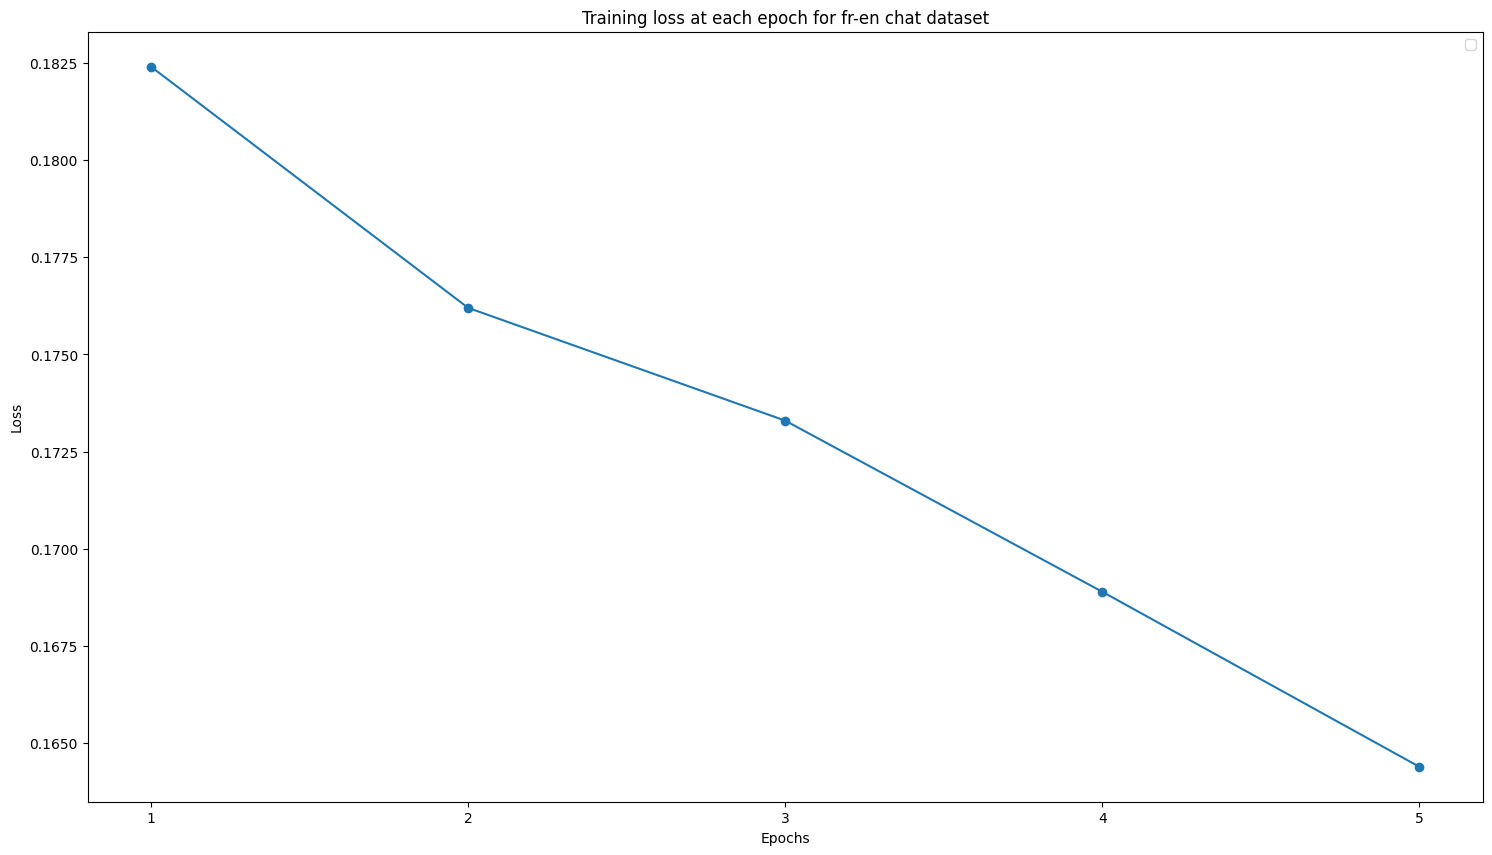

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,10))
epochs = [1,2,3,4,5]
loss = [0.1824, 0.1762, 0.1733, 0.1689, 0.1644]
plt.plot(epochs, loss, marker='o')
plt.title('Training loss at each epoch for fr-en chat dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(epochs)
plt.legend()
plt.show()

In [21]:
trainer.save_model(output_dir = './de_en_chat_model')
tokenizer.save_pretrained('./de_en_chat_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}


('./de_en_chat_model/tokenizer_config.json',
 './de_en_chat_model/special_tokens_map.json',
 './de_en_chat_model/vocab.json',
 './de_en_chat_model/source.spm',
 './de_en_chat_model/target.spm',
 './de_en_chat_model/added_tokens.json')

In [22]:
from transformers import *
import torch
model = AutoModelForSeq2SeqLM.from_pretrained('./de_en_chat_model')
tokenizer = AutoTokenizer.from_pretrained('./de_en_chat_model')

/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/.venv/lib/python3.12/site-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
loading configuration file ./de_en_chat_model/config.json
Model config MarianConfig {
  "_name_or_path": "./de_en_chat_model",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      58100
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 58100,
  "decoder_vocab_size": 58101,
  "dropout": 0.1,
  "encoder_atten

In [23]:
def tokenize_function(example):
    try:
        inputs = example['source_text']
        targets = example['target_text']
        
        if not isinstance(inputs,(str,list)):
            inputs = str(inputs)
        if not isinstance(targets,(str,list)):
            targets = str(targets)
                
        return tokenizer(example['source_text'], padding='max_length', max_length=128, truncation=True)
    except Exception as e:
            print(e)
    
tokenized_dataset = dataset['val'].map(tokenize_function, batched=True)
    

input_ids = torch.tensor(tokenized_dataset['input_ids'])
attention_mask = torch.tensor(tokenized_dataset['attention_mask'])


Map:   0%|          | 0/2569 [00:00<?, ? examples/s]

In [24]:
model.eval()
predictions = []
with torch.no_grad():
    for input_id, attention_msk in zip(input_ids, attention_mask):
        output = model.generate(input_ids=input_id.unsqueeze(0), attention_mask=attention_msk.unsqueeze(0))
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)


In [25]:
val_texts = val_data['target_text'].tolist()
len(val_texts)

2569

In [26]:
import evaluate
actual = val_texts
predicted = predictions
bleu = evaluate.load('bleu')
bleu_score = bleu.compute(predictions = predicted,references = actual)
print(f'BLEU Score: {bleu_score}')

BLEU Score: {'bleu': 0.43360794586607154, 'precisions': [0.6796395771963265, 0.4762991706611885, 0.3675443762093043, 0.29711231951997], 'brevity_penalty': 1.0, 'length_ratio': 1.0234810059234563, 'translation_length': 28855, 'reference_length': 28193}


In [27]:
sacrebleu = evaluate.load('sacrebleu')
sacrebleu_score = sacrebleu.compute(predictions = predicted,references = actual)
print(f'SACREBLEU Score: {sacrebleu_score}')

SACREBLEU Score: {'score': 43.36079458660715, 'counts': [19611, 12520, 8738, 6338], 'totals': [28855, 26286, 23774, 21332], 'precisions': [67.96395771963265, 47.62991706611885, 36.754437620930425, 29.711231951997], 'bp': 1.0, 'sys_len': 28855, 'ref_len': 28193}


/var/folders/xr/ww1bx5dx03ncctbbx4zptmcm0000gn/T/ipykernel_4754/3058270106.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


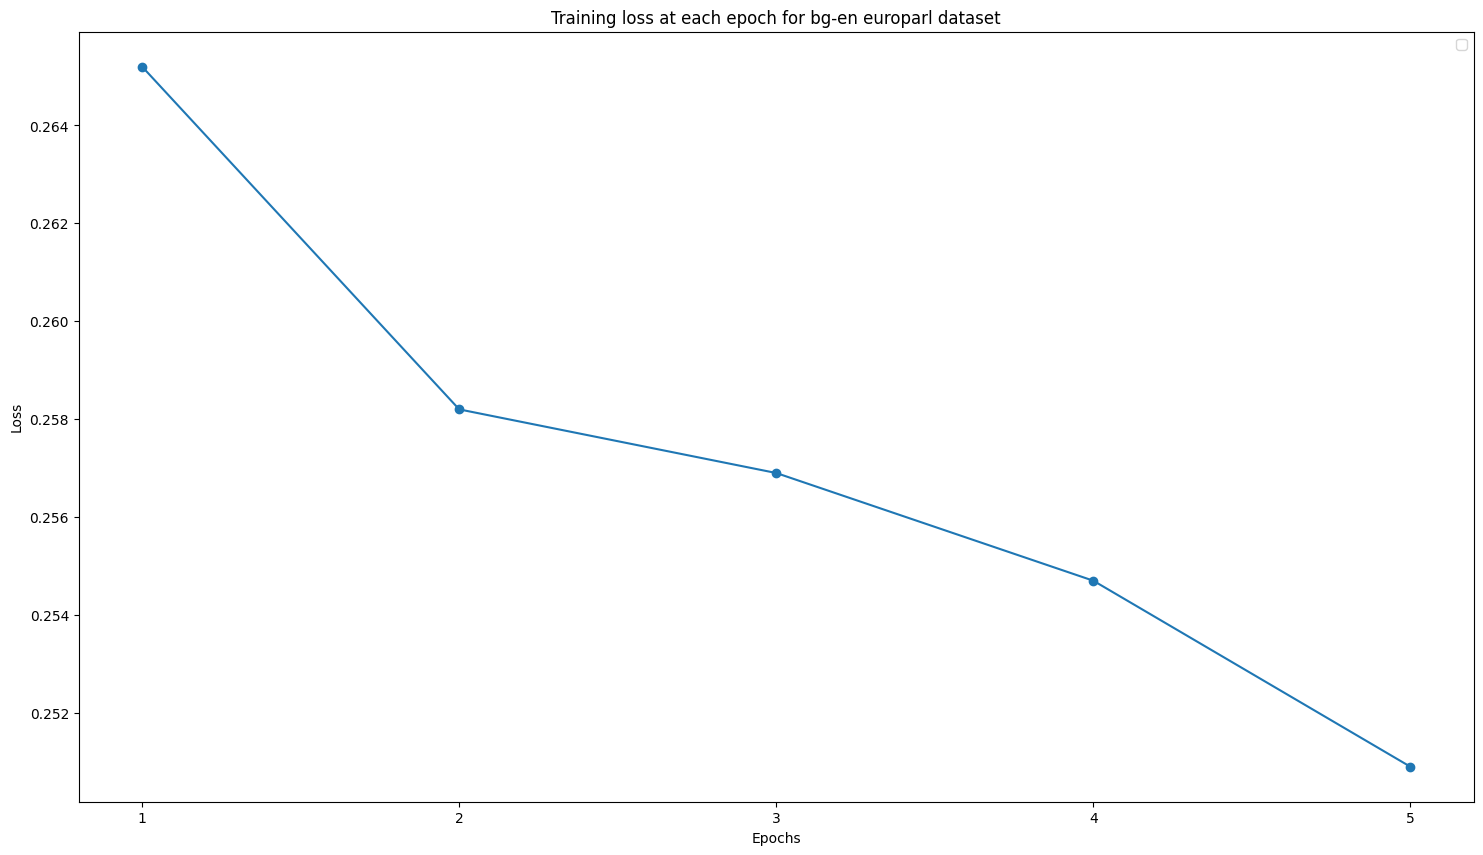

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,10))
epochs = [1,2,3,4,5]
loss = [0.2652, 0.2582, 0.2569, 0.2547,0.2509]
plt.plot(epochs, loss, marker='o')
plt.title('Training loss at each epoch for bg-en europarl dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(epochs)
plt.legend()
plt.show()

## Configured till above